In [251]:
import numpy as np 
import pandas as pd 
import os
import tempfile


import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.pipeline import Pipeline
      
    
import tensorflow as tf
from tensorflow import keras
from tqdm.keras import TqdmCallback

In [252]:
import optuna
from optuna.visualization import plot_optimization_history,  plot_param_importances


import warnings
warnings.filterwarnings("ignore")

OPTUNA = False
REFINE = False

In [253]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [254]:
train.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [255]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

def plot_curves(hist):
    
    # create subplots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
    
    # plot accuracy curve
    ax[0].plot(hist.history['auc'])
    ax[0].plot(hist.history['val_auc'])
    ax[0].set_title('model auc')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('auc')
    ax[0].legend(['train', 'val'], loc='best')
    
    # plot loss curve
    ax[1].plot(hist.history['loss'])
    ax[1].plot(hist.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'val'], loc='upper right')    
    
    plt.show()
    
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [256]:
corr_features = correlation(train, 0.95)
corr_features

{'branchCount', 'total_Op', 'total_Opnd'}

In [257]:
# Split data

In [258]:
X = train.drop(['id', 'defects'] 
               #+ list(corr_features)
               , axis = 1)
y = train['defects'].apply(int)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3,random_state=42)

In [259]:
# Make Yeo-johnson transformation

In [260]:
pipe_prep = Pipeline(         
    [
   ('Yeo-johnson transformation', PowerTransformer(standardize=True))
    ]
)

train_features = pipe_prep.fit_transform(X_train)
val_features = pipe_prep.transform(X_valid)

In [261]:
# Set the baseline model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4453)              97966     
                                                                 
 dense_1 (Dense)             (None, 15)                66810     
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 15)                240       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_3 (Dense)             (None, 15)                240       
                                                                 
 dropout_2 (Dropout)         (None, 15)                0

100%|█| 70/70 [00:17<00:00,  3.96epoch/s, loss=0.445, tp=5355.0, fp=2961.0, tn=52128.0, fn=10790.0, accuracy=0.807, pre


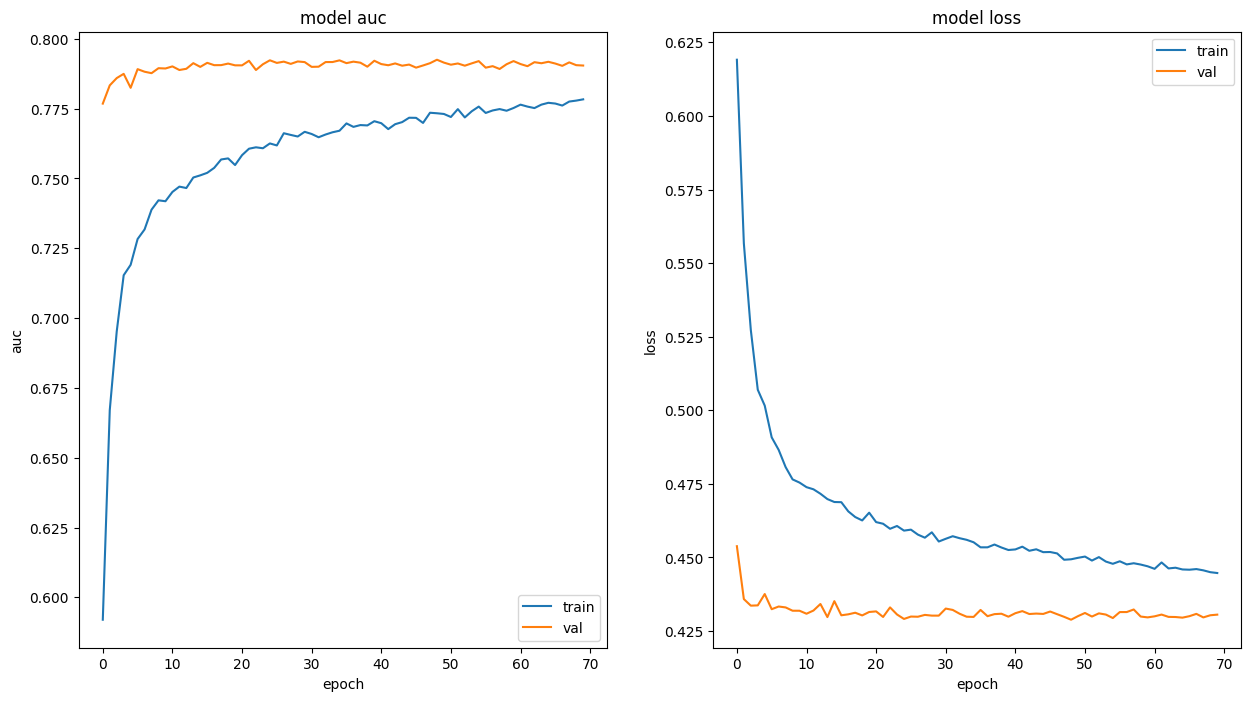

In [262]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(batch_size=None,nodes=None,input_shape=None,output_shape=None, output_bias=None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(batch_size, input_shape=(input_shape,), activation='relu'))
    model.add(keras.layers.Dense(nodes, activation='elu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(nodes, activation='elu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(nodes, activation='elu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(nodes, activation='elu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(output_shape, activation='sigmoid'))
    return model

    return model

weight_for_0, weight_for_1 = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

# Params
INPUT_SHAPE = X_train.shape[1]                                                          
OUTPUT_SHAPE = 1                                                        
NODES = np.ceil(2 * INPUT_SHAPE / 3 + OUTPUT_SHAPE).astype(int)                        
BATCH_SIZE = np.ceil(len(X_train) / 16).astype(int)
EPOCHS = 70
TRIALS = 70
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}

neg, pos = np.bincount(train['defects'])
INITIAL_BIAS = np.log([pos/neg])

# set early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# baseline model
baseline_model = make_model(BATCH_SIZE,NODES,INPUT_SHAPE,OUTPUT_SHAPE, INITIAL_BIAS)

# compile model
baseline_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

# model summary
baseline_model.summary()

# clear session
tf.keras.backend.clear_session()

# train model
baseline_hist = baseline_model.fit(train_features
          , y_train
          , epochs = EPOCHS
          , batch_size=BATCH_SIZE
          , shuffle=True
          , validation_data=(val_features, y_valid)
          , verbose=0
          , callbacks=[TqdmCallback(verbose=0)]
          , class_weight=None#class_weight
          )


plot_curves(baseline_hist)

In [263]:
# Utility function to create model trials

In [264]:
def create_model(trial):
    # We optimize the numbers of layers, their units and learning rates 
    n_layers = trial.suggest_int("n_layers", 1, 10)
    n_nodes = trial.suggest_int('n_nodes', 100, 1000)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 2000, 6000)
    activation_func_main = trial.suggest_categorical('activation_func_main' , ['relu', 'tanh', 'sigmoid', 'gelu', 'elu', 'softplus'])
    activation_func = trial.suggest_categorical('activation_func' , ['relu', 'tanh', 'sigmoid', 'gelu', 'elu', 'softplus'])
    class_weight = trial.suggest_categorical('class_weight' , [CLASS_WEIGHT, None])
    dropout = trial.suggest_loguniform('dropout', 1e-5, 5e-1)
    dropout_first = trial.suggest_loguniform('dropout_first', 1e-5, 5e-1)
    
    # build model
    model = keras.models.Sequential()
    
    # add input layer
    model.add(keras.layers.Dense(batch_size, input_shape=(INPUT_SHAPE,), activation=activation_func_main))
    
    # add dropout layer
    model.add(keras.layers.Dropout(dropout_first))
    
    # dynamically add hidden layers through trial
    for i in range(n_layers):
        model.add(keras.layers.Dense(n_nodes, activation = activation_func
                                    ))
    
        # add hidden dropout layer
        model.add(keras.layers.Dropout(dropout))
        
    # add output layer
    model.add(keras.layers.Dense(OUTPUT_SHAPE,activation='sigmoid'))
    
    # compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=METRICS)
    
    return model

# Objective function
def objective(trial):
    
    # instantiate model
    model_opt = create_model(trial)
    
    # fit the model
    model_opt.fit(  train_features
                  , y_train
                  , epochs = EPOCHS
                  , batch_size=BATCH_SIZE
                  , shuffle=True
                  , validation_data=(val_features, y_valid)
                  , verbose=0
                  , callbacks=[TqdmCallback(verbose=0)]
                 )
                  
    # calculate auc score
    score = model_opt.evaluate(val_features, y_valid, verbose=0)[-2]
    
    return score

In [265]:
if OPTUNA:
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize", study_name="baseline model optimization")
    study.optimize(objective, n_trials=TRIALS, n_jobs=-1)

In [266]:
if OPTUNA:
    # print out 
    print('*'*100)
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("Best Params:")
    print(study.best_params)
    print('*'*100)

In [267]:
if OPTUNA:
    plotly_config = {"staticPlot": True}
    fig = plot_optimization_history(study)
    fig.show(config=plotly_config)

In [268]:
if OPTUNA:
    fig = plot_param_importances(study)
    fig.show(config=plotly_config)

In [269]:
# Get the optimized model

In [270]:
def create_model_opt(n_layers, n_nodes, learning_rate, batch_size, activation_func_main, activation_func, dropout,dropout_first):
    
    # build model
    model = keras.models.Sequential()
    
    # add input layer
    model.add(keras.layers.Dense(batch_size, input_shape=(INPUT_SHAPE,), activation=activation_func_main))
    
    # add dropout layer
    model.add(keras.layers.Dropout(dropout_first))
    
    # dynamically add hidden layers through trial
    for i in range(n_layers):
        model.add(keras.layers.Dense(n_nodes, activation = activation_func
                                    ))
    
        # add hidden dropout layer
        model.add(keras.layers.Dropout(dropout))
    
    
    
    # add output layer
    model.add(keras.layers.Dense(OUTPUT_SHAPE,activation='sigmoid'))
    
    # compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=METRICS)
    
    return model

In [271]:
if OPTUNA:
    baseline_model_opt = create_model(study.best_trial)
    
else:
    
    params = {'n_layers': 10, 'n_nodes': 719, 'learning_rate': 8.329523338978406e-05, 'batch_size': 5151, 'activation_func_main': 'relu', 'activation_func': 'gelu', 'dropout': 0.3722474640092899, 'dropout_first': 0.010531629258436202}
    baseline_model_opt = create_model_opt(**params) 
    #3151
baseline_model_opt.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5151)              113322    
                                                                 
 dropout (Dropout)           (None, 5151)              0         
                                                                 
 dense_1 (Dense)             (None, 719)               3704288   
                                                                 
 dropout_1 (Dropout)         (None, 719)               0         
                                                                 
 dense_2 (Dense)             (None, 719)               517680    
                                                                 
 dropout_2 (Dropout)         (None, 719)               0         
                                                                 
 dense_3 (Dense)             (None, 719)               5

  0%|                                                                                        | 0/70 [00:00<?, ?epoch/s]

100%|█| 70/70 [00:49<00:00,  1.41epoch/s, loss=0.43, tp=6329.0, fp=3278.0, tn=51811.0, fn=9816.0, accuracy=0.816, preci


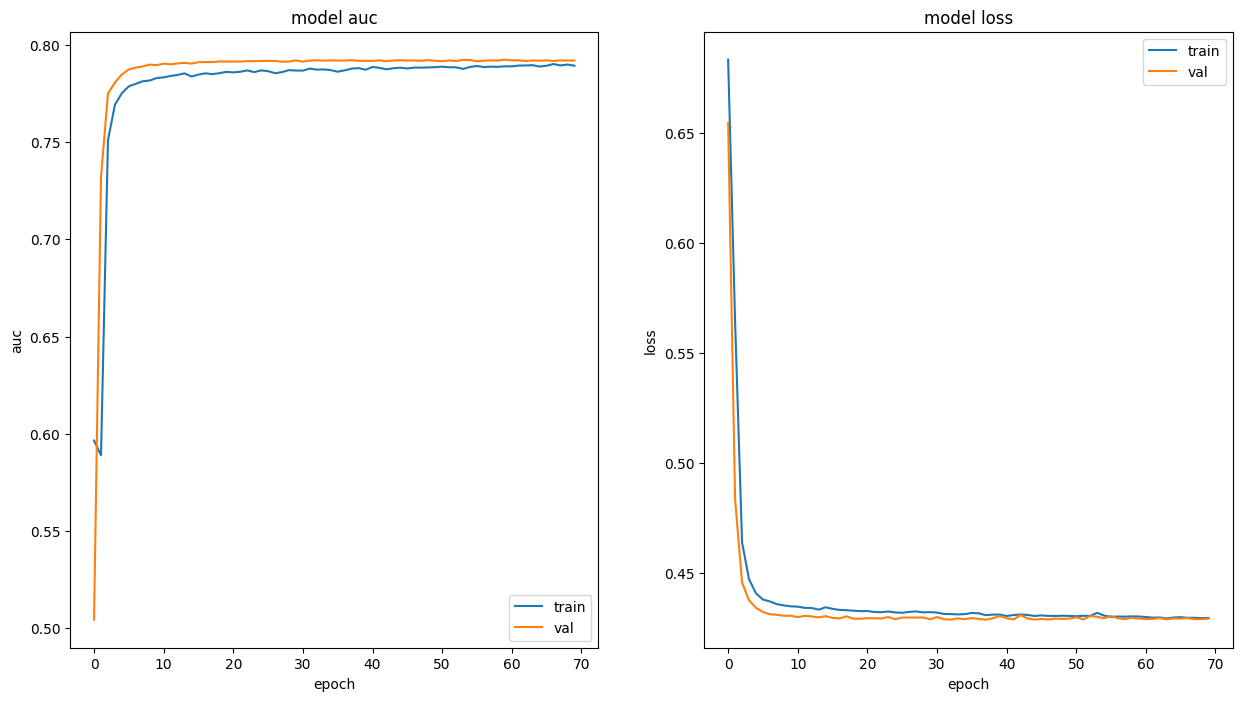

In [272]:
# clear session
tf.keras.backend.clear_session()

# train model
baseline_hist_opt = baseline_model_opt.fit(train_features
                                          ,y_train
                                          ,epochs = EPOCHS
                                          ,batch_size = study.best_trial.params['batch_size'] if OPTUNA else BATCH_SIZE
                                          ,shuffle=True
                                          ,validation_data=(val_features, y_valid)
                                          ,verbose=0
                                          ,callbacks=[TqdmCallback(verbose=0)]
                                          ,class_weight = study.best_trial.params['class_weight'] if OPTUNA else None
                                          )

# plot
plot_curves(baseline_hist_opt)

In [273]:
# Prepare test data

In [274]:
test_features = pipe_prep.transform(test.drop(['id'] #+ list(corr_features) 
                                           , axis = 1))

In [277]:
len(test_features)

67842

In [278]:
test.id

0        101763
1        101764
2        101765
3        101766
4        101767
          ...  
67837    169600
67838    169601
67839    169602
67840    169603
67841    169604
Name: id, Length: 67842, dtype: int64

In [246]:
# Get predictions

16/16 [==============================] - 1s 27ms/step


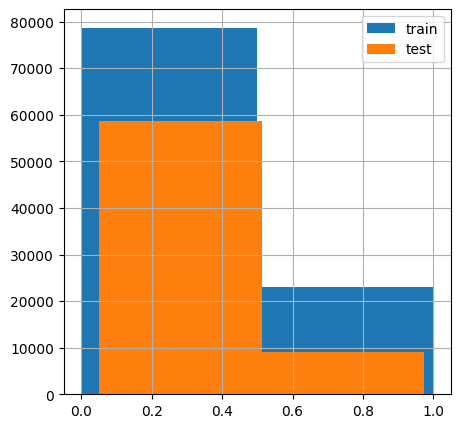

In [247]:
preds_baseline = baseline_model_opt.predict(test_features, batch_size=BATCH_SIZE).squeeze()
submission_baseline_opt = pd.DataFrame({'id':test.id, 'defects': preds_baseline})
plt.figure(figsize=(5,5))
train.defects.astype(int).hist(label='train',bins=2)
(submission_baseline_opt.defects).hist(label='test',bins=2)
plt.legend();

In [248]:
submission_baseline_opt

,id,defects
0,101763,0.258619
1,101764,0.191830
2,101765,0.710603
3,101766,0.516483
4,101767,0.126442
...,...,...
67837,169600,0.286999
67838,169601,0.112372
67839,169602,0.194055
67840,169603,0.080616


In [249]:
if REFINE:
    submission_baseline_opt.defects -= min(submission_baseline_opt.defects)
    submission_baseline_opt.defects /= max(submission_baseline_opt.defects)

    plt.figure(figsize=(5,5))
    train.defects.astype(int).hist(label='train',bins=2)
    (submission_baseline_opt.defects).hist(label='test',bins=2)
    plt.legend();

In [250]:
submission_baseline_opt.to_csv('submission2.csv', index = False)